In [1]:
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

['sir',
 'two_moons',
 'slcp',
 'gaussian_linear_uniform',
 'lotka_volterra',
 'bernoulli_glm',
 'gaussian_mixture',
 'gaussian_linear',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [2]:
task_name = "gaussian_mixture"

In [187]:
encoder.parameters()

<generator object Module.parameters at 0x7f33f3fd30b0>

In [3]:

task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()   

device = "cuda:0"
    
fn = f"{task_name}"
cached_fn = f"{fn}.nf"
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=2, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=29, bias=True)
        )
      )
      (1): LULinear()
      (2): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer):

In [161]:
total_trials = 10

trial_sims = 10_000 # same number for both test and calibration
sims = (total_trials + 1) * trial_sims

theta = prior.sample((sims,))
x = simulator(theta)

# very weird, but something odd happens on certain simulation runs if we generate test data at
# test time -- just generate all data (both test and calibration) ahead of time to avoid this
thetas = np.split(theta, sims // trial_sims)
xs = np.split(x, sims // trial_sims)

calibration_theta = thetas[0]
calibration_x = xs[0]

test_thetas = thetas[1:]
test_xs = xs[1:]

In [162]:

num_coverage_pts = 20
desired_coverages = [(1 / num_coverage_pts) * k for k in range(num_coverage_pts)]

cal_scores = 1 / encoder.log_prob(calibration_theta.to(device), calibration_x.to(device)).detach().cpu().exp().numpy()
conformal_quantiles = np.array([np.quantile(cal_scores, q = coverage) for coverage in desired_coverages])

In [163]:
def coverage_trial(test_theta, test_x):
    test_scores = 1 / encoder.log_prob(test_theta.to(device), test_x.to(device)).detach().cpu().exp().numpy()
    return [np.sum(test_scores < conformal_quantile) / trial_sims for conformal_quantile in conformal_quantiles]

In [179]:
dfs = []
for i in range(total_trials):
    df = pd.DataFrame(columns=["confidence", "coverages"])
    df["confidence"] = desired_coverages
    df["coverages"] = coverage_trial(test_thetas[i], test_xs[i])
    dfs.append(df)
df = pd.concat(dfs)   

In [ ]:
empirical_theta_dist = encoder.sample((trial_sims,))

<Axes: xlabel='confidence', ylabel='confidence'>

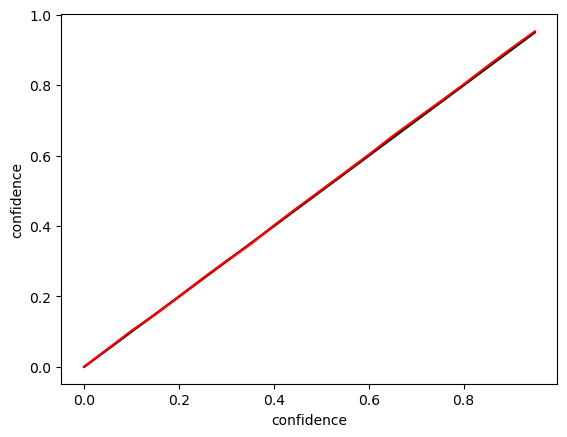

In [183]:
sns.lineplot(data=df, x="confidence", y="confidence", color="black", linestyle="-")
sns.lineplot(data=df, x="confidence", y="coverages", color="red", linestyle="-")